# Model Checker Solver Performance Comparison

This notebook analyzes the performance of different model checking solvers by comparing their execution times across the same benchmark cases. It will generate visualization plots for:

1. Scatter plots comparing solver performance (log-log scale)
2. Speedup comparison between solvers
3. Performance profile showing the distribution of solving efficiency

**Note:** Only cases where all solvers have valid results will be included in the analysis.

In [1]:
# Import required libraries
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

# Set base directory
BENCHMARK_DIR = "/Users/huguangyu/coding_env/MC-aig-only-benchmark"
ABC_DIR = os.path.join(BENCHMARK_DIR, "abc_solver_logs")
RIC3_BASELINE_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_baseline_logs")
RIC3_DYNAMIC_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_dynamic_logs")
RIC3_ADAPTIVE_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_adaptive_logs")
RIC3_REVERSE_TOPO_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_reverse_topo_logs")
RIC3_REVERSE_TOPO_INN_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_reverse_topo_inn_logs")
RIC3_FLIP_HIGH_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_flip_high_logs")
RIC3_DYNAMIC_REVERSE_TOPO_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_reverse_topo_dynamic_logs")
RIC3_MULTI_MIC_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_multi_mic_logs")
RIC3_MAB_DIR = os.path.join(BENCHMARK_DIR, "rIC3_solver_mab2_logs")

## Functions for Extracting Solver Data

The following functions extract solving times from log files for different solvers.

In [2]:
def extract_time_from_abc_log(log_path):
    """Extract solving time from ABC solver log file"""
    try:
        with open(log_path, 'r') as f:
            content = f.read()
            # Check if timeout
            if "STATUS: TIMEOUT" in content:
                return 3600  # Return timeout value (3600 seconds)
            
            # Try to find the completion time
            time_match = re.search(r'(\d+\.\d+) sec', content)
            if time_match:
                return float(time_match.group(1))
            
            # If no time found but completed
            if "STATUS: COMPLETED" in content:
                # Look for the last time entry in the frame data
                time_entries = re.findall(r'\s+(\d+\.\d+) sec', content)
                if time_entries:
                    return float(time_entries[-1])
        
        return None  # Could not parse time
    except Exception as e:
        print(f"Error parsing {log_path}: {e}")
        return None

def extract_time_from_ric3_log(log_path):
    """Extract solving time from rIC3 solver log file"""
    try:
        with open(log_path, 'r') as f:
            content = f.read()
            
            # Check if timeout
            if "STATUS: TIMEOUT" in content:
                return 3600  # Return timeout value
            
            # Extract time from statistics
            time_match = re.search(r'time: (\d+\.\d+)s', content)
            if time_match:
                return float(time_match.group(1))
        
        return None  # Could not parse time
    except Exception as e:
        print(f"Error parsing {log_path}: {e}")
        return None

## Finding Common Cases Across All Solvers

We only want to include cases where all solvers have log files available.

In [3]:
def find_common_cases(abc_dir, ric3_baseline_dir, ric3_dynamic_dir, ric3_adaptive_dir, ric3_reverse_topo_dir, ric3_reverse_topo_inn_dir, ric3_flip_high_dir, ric3_dynamic_reverse_topo_dir, ric3_multi_mic_dir, ric3_mab_dir):
    """Find cases that exist in all three log directories"""
    abc_logs = {os.path.basename(f) for f in glob.glob(os.path.join(abc_dir, "*.txt"))}
    ric3_baseline_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_baseline_dir, "*.txt"))}
    ric3_dynamic_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_dynamic_dir, "*.txt"))}
    ric3_adaptive_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_adaptive_dir, "*.txt"))}
    ric3_reverse_topo_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_reverse_topo_dir, "*.txt"))}
    ric3_reverse_topo_inn_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_reverse_topo_inn_dir, "*.txt"))}
    ric3_flip_high_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_flip_high_dir, "*.txt"))}
    ric3_dynamic_reverse_topo_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_dynamic_reverse_topo_dir, "*.txt"))}
    ric3_multi_mic_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_multi_mic_dir, "*.txt"))}
    ric3_mab_logs = {os.path.basename(f) for f in glob.glob(os.path.join(ric3_mab_dir, "*.txt"))}
    
    # Find common log files across all three directories
    common_logs = abc_logs.intersection(ric3_baseline_logs, ric3_dynamic_logs, ric3_adaptive_logs, ric3_reverse_topo_logs, ric3_reverse_topo_inn_logs, ric3_flip_high_logs, ric3_dynamic_reverse_topo_logs, ric3_multi_mic_logs, ric3_mab_logs)
    return common_logs

# Find common cases
common_cases = find_common_cases(ABC_DIR, RIC3_BASELINE_DIR, RIC3_DYNAMIC_DIR, RIC3_ADAPTIVE_DIR, RIC3_REVERSE_TOPO_DIR, RIC3_REVERSE_TOPO_INN_DIR, RIC3_FLIP_HIGH_DIR, RIC3_DYNAMIC_REVERSE_TOPO_DIR, RIC3_MULTI_MIC_DIR, RIC3_MAB_DIR)
print(f"Found {len(common_cases)} common cases across all solvers")

Found 2975 common cases across all solvers


## Extracting Solving Times

Now we'll extract the solving times for each case and store them in a DataFrame.

In [4]:
# Create a DataFrame to store the results
results_data = []

# Process each case and extract times
for case in common_cases:
    abc_time = extract_time_from_abc_log(os.path.join(ABC_DIR, case))
    ric3_baseline_time = extract_time_from_ric3_log(os.path.join(RIC3_BASELINE_DIR, case))
    ric3_dynamic_time = extract_time_from_ric3_log(os.path.join(RIC3_DYNAMIC_DIR, case))
    ric3_adaptive_time = extract_time_from_ric3_log(os.path.join(RIC3_ADAPTIVE_DIR, case))
    ric3_reverse_topo_time = extract_time_from_ric3_log(os.path.join(RIC3_REVERSE_TOPO_DIR, case))
    ric3_reverse_topo_inn_time = extract_time_from_ric3_log(os.path.join(RIC3_REVERSE_TOPO_INN_DIR, case))
    ric3_flip_high_time = extract_time_from_ric3_log(os.path.join(RIC3_FLIP_HIGH_DIR, case))    
    ric3_reverse_topo_dynamic_time = extract_time_from_ric3_log(os.path.join(RIC3_DYNAMIC_REVERSE_TOPO_DIR, case))
    ric3_multi_mic_time = extract_time_from_ric3_log(os.path.join(RIC3_MULTI_MIC_DIR, case))
    ric3_mab_time = extract_time_from_ric3_log(os.path.join(RIC3_MAB_DIR, case))
    
    # Only include case if all solvers have valid results
    if abc_time is not None and ric3_baseline_time is not None and ric3_dynamic_time is not None and ric3_adaptive_time is not None and ric3_reverse_topo_time is not None and ric3_reverse_topo_inn_time is not None and ric3_flip_high_time is not None and ric3_reverse_topo_dynamic_time is not None and ric3_multi_mic_time is not None and ric3_mab_time is not None:
        results_data.append({
            "case": case.replace("_log.txt", ""),
            "abc": abc_time,
            "ric3_baseline": ric3_baseline_time,
            "ric3_dynamic": ric3_dynamic_time,
            "ric3_adaptive": ric3_adaptive_time,
            "ric3_reverse_topo": ric3_reverse_topo_time,
            "ric3_reverse_topo_inn": ric3_reverse_topo_inn_time,
            "ric3_flip_high": ric3_flip_high_time,
            "ric3_dynamic_reverse_topo": ric3_reverse_topo_dynamic_time,
            "ric3_multi_mic": ric3_multi_mic_time,
            "ric3_mab": ric3_mab_time
        })

# Create DataFrame
results_df = pd.DataFrame(results_data)
print(f"Successfully parsed {len(results_df)} cases with valid times from all solvers")

# Display the first few rows
results_df.head()

Successfully parsed 2879 cases with valid times from all solvers


case      abc  ric3_baseline  ric3_dynamic  ric3_adaptive  \
0           6s32  3600.00        3600.00       3600.00        3600.00   
1  bobtuint30neg     0.00           0.03          0.04           0.05   
2      139463p24     0.22           6.28          6.52           5.10   
3         cal198  3600.00        3600.00       3600.00        3600.00   
4          gen43     0.60           0.27          0.27           0.32   

   ric3_reverse_topo  ric3_reverse_topo_inn  ric3_flip_high  \
0            3600.00                3600.00         3600.00   
1               0.03                   0.01            0.03   
2               3.12                  30.61            4.38   
3            3600.00                3600.00         3600.00   
4               0.28                   0.08            0.28   

   ric3_dynamic_reverse_topo  ric3_multi_mic  ric3_mab  
0                    3600.00            0.21   2270.95  
1                       0.03            0.03      0.05  
2                       3.55            6.60      1.62  
3                    3600.00         3600.00   3600.00  
4                       0.28            0.55      0.24

## Scatter Plot Comparisons

Create scatter plots to compare the performance of different solvers.

rIC3 Baseline faster than ABC: 1429 cases (49.6%)
Baseline vs ABC ratio statistics:
count    2546.00
mean         inf
std          NaN
min         0.00
25%         1.00
50%         2.00
75%       114.75
max          inf
Name: baseline_speedup, dtype: float64
rIC3 Dynamic faster than ABC: 1431 cases (49.7%)
Dynamic vs ABC ratio statistics:
count    2543.000000
mean             inf
std              NaN
min         0.000000
25%         1.000000
50%         2.000000
75%       117.071429
max              inf
Name: dynamic_speedup, dtype: float64


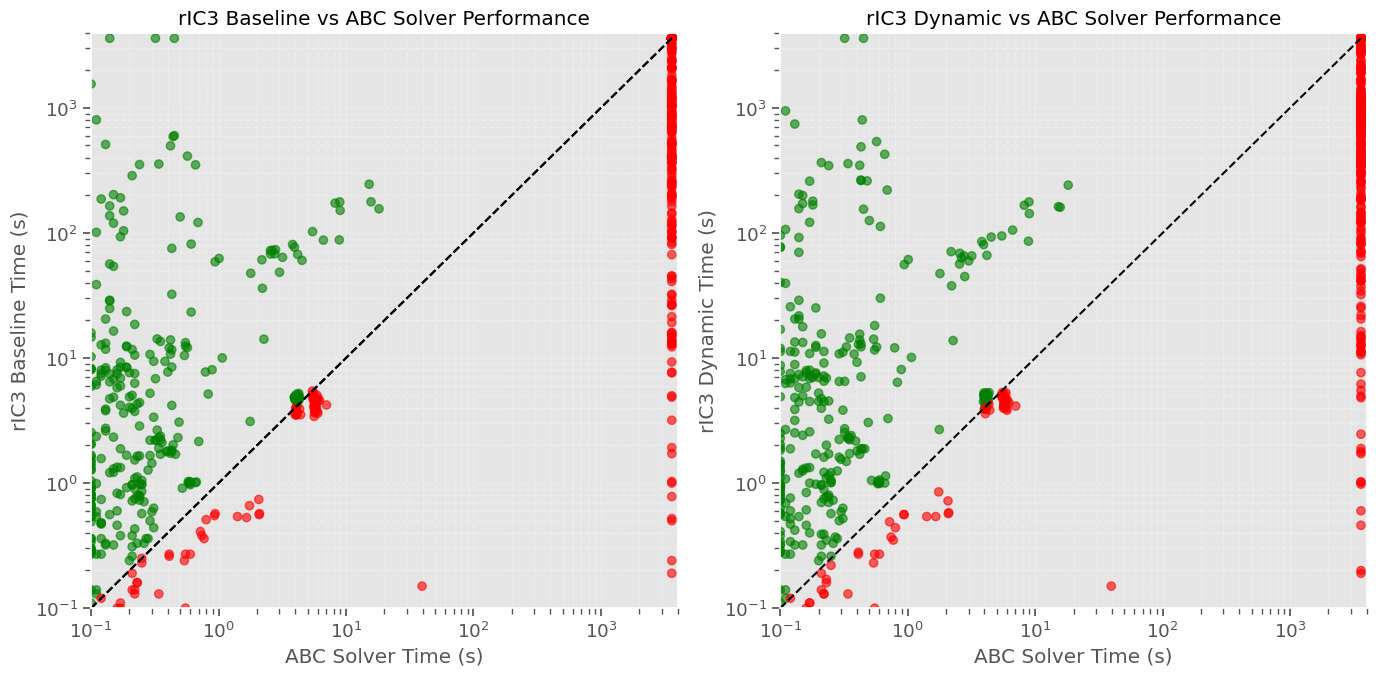

In [5]:
plt.figure(figsize=(14, 7))

total_cases = len(results_df)

# Plot 1: rIC3 Baseline vs ABC
plt.subplot(1, 2, 1)
results_df["baseline_speedup"] = results_df["ric3_baseline"] / results_df["abc"]
baseline_faster_count = sum(results_df["baseline_speedup"] > 1)

plt.scatter(
    results_df["abc"], 
    results_df["ric3_baseline"], 
    alpha=0.6, 
    c=results_df["baseline_speedup"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ABC Solver Time (s)')
plt.ylabel('rIC3 Baseline Time (s)')
plt.title('rIC3 Baseline vs ABC Solver Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

print(f"rIC3 Baseline faster than ABC: {baseline_faster_count} cases ({baseline_faster_count/total_cases:.1%})")
print("Baseline vs ABC ratio statistics:")
print(results_df["baseline_speedup"].describe())
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ABC Solver Time (s)')
plt.ylabel('rIC3 Baseline Time (s)')
plt.title('rIC3 Baseline vs ABC Solver Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

# Plot 2: rIC3 Dynamic vs ABC
plt.subplot(1, 2, 2)
results_df["dynamic_speedup"] = results_df["ric3_dynamic"] / results_df["abc"]
dynamic_faster_count = sum(results_df["dynamic_speedup"] > 1)

plt.scatter(
    results_df["abc"], 
    results_df["ric3_dynamic"], 
    alpha=0.6, 
    c=results_df["dynamic_speedup"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ABC Solver Time (s)')
plt.ylabel('rIC3 Dynamic Time (s)')
plt.title('rIC3 Dynamic vs ABC Solver Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

print(f"rIC3 Dynamic faster than ABC: {dynamic_faster_count} cases ({dynamic_faster_count/total_cases:.1%})")
print("Dynamic vs ABC ratio statistics:")
print(results_df["dynamic_speedup"].describe())

plt.tight_layout()
plt.savefig('solver_comparison.png', dpi=300)
plt.show()

## Additional Analysis: Direct Comparison of rIC3 Implementations

Compare the dynamic and baseline implementations of rIC3 to each other.

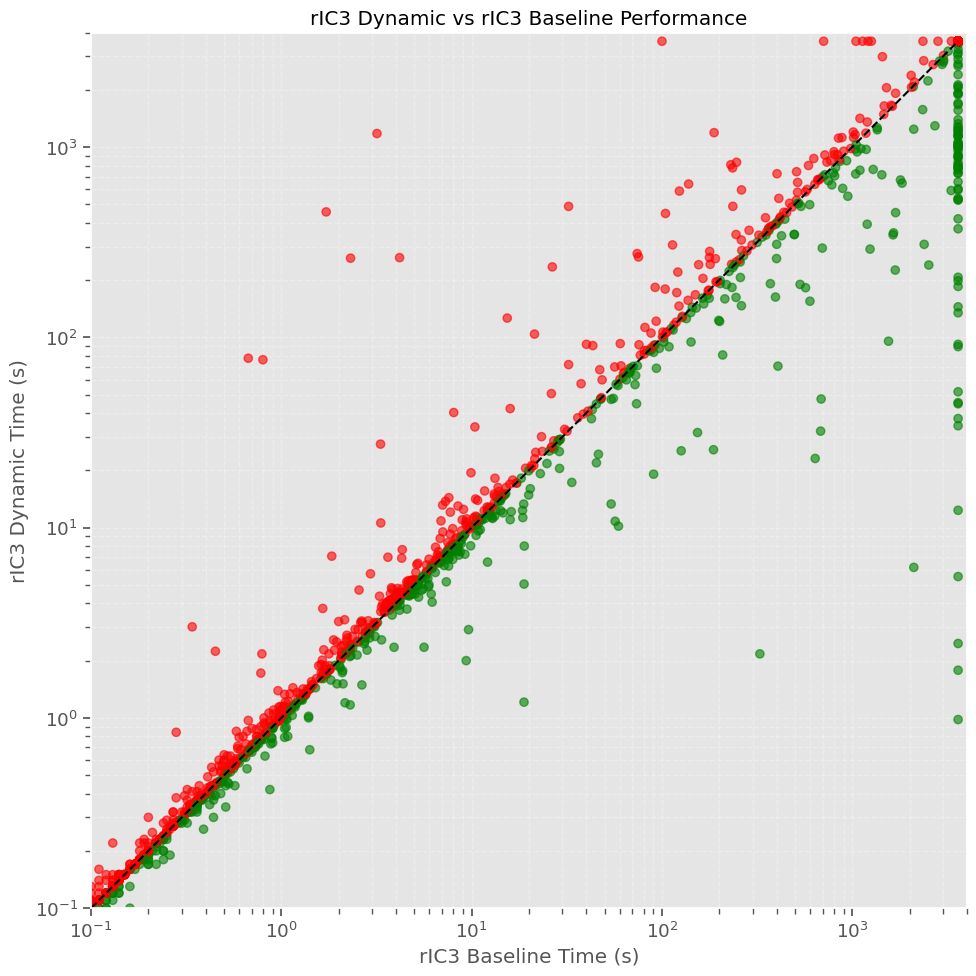

rIC3 Dynamic faster than rIC3 Baseline: 1865 cases (64.8%)
Dynamic vs Baseline ratio statistics:
count    2463.0
mean        inf
std         NaN
min         0.0
25%         1.0
50%         1.0
75%         1.0
max         inf
Name: dynamic_vs_baseline_ratio, dtype: float64


In [6]:
plt.figure(figsize=(10, 10))

# Create dynamic vs baseline ratio
results_df["dynamic_vs_baseline_ratio"] = results_df["ric3_baseline"] / results_df["ric3_dynamic"]
dynamic_faster_count = sum(results_df["dynamic_vs_baseline_ratio"] >= 1)

total_cases = len(results_df)

plt.scatter(
    results_df["ric3_baseline"], 
    results_df["ric3_dynamic"], 
    alpha=0.6, 
    c=results_df["dynamic_vs_baseline_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Baseline Time (s)')
plt.ylabel('rIC3 Dynamic Time (s)')
plt.title('rIC3 Dynamic vs rIC3 Baseline Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_comparison_dynamic_vs_baseline.png', dpi=300)
plt.show()

print(f"rIC3 Dynamic faster than rIC3 Baseline: {dynamic_faster_count} cases ({dynamic_faster_count/total_cases:.1%})")
print("Dynamic vs Baseline ratio statistics:")
print(results_df["dynamic_vs_baseline_ratio"].describe())

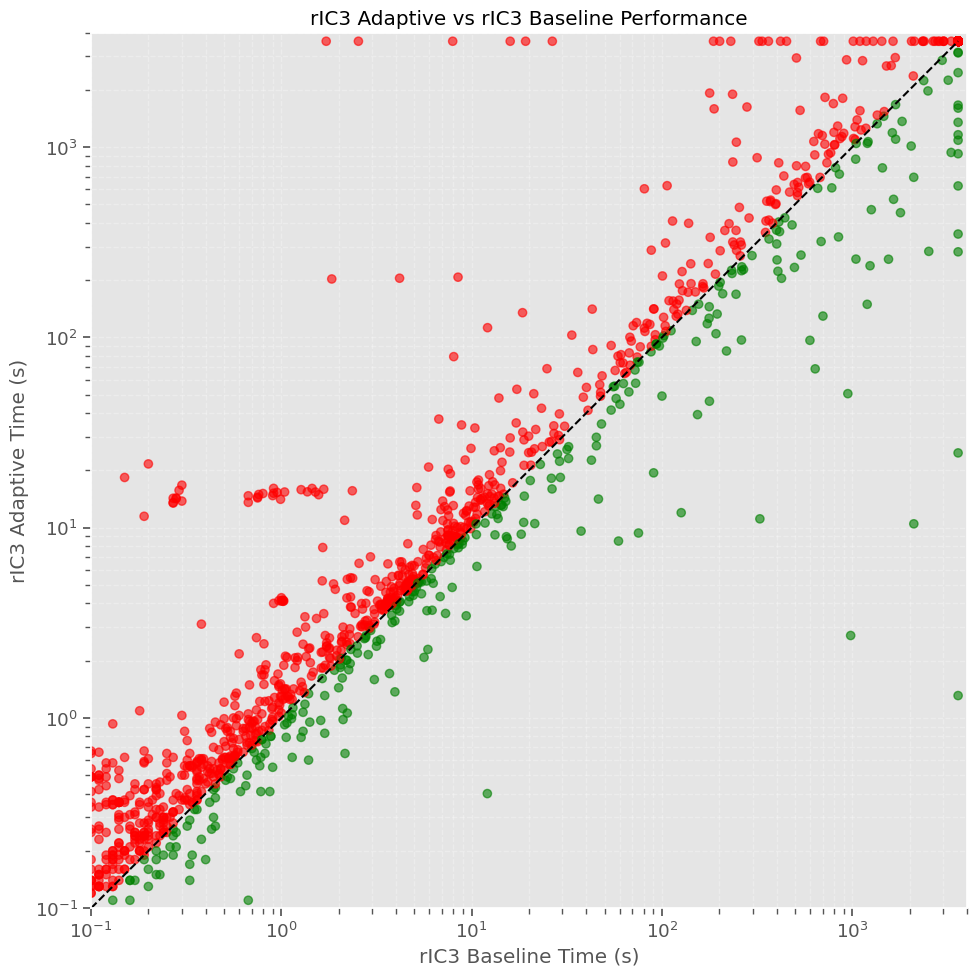

rIC3 Adaptive faster than rIC3 Baseline: 306 cases (10.6%)
Adaptive vs Baseline ratio statistics:
count    2798.000000
mean             inf
std              NaN
min         0.000000
25%         0.333333
50%         0.805715
75%         1.000000
max              inf
Name: adaptive_vs_baseline_ratio, dtype: float64


In [7]:
plt.figure(figsize=(10, 10))

# Create adaptive vs baseline ratio
results_df["adaptive_vs_baseline_ratio"] = results_df["ric3_baseline"] / results_df["ric3_adaptive"]
adaptive_faster_count = sum(results_df["adaptive_vs_baseline_ratio"] > 1)

total_cases = len(results_df)

plt.scatter(
    results_df["ric3_baseline"], 
    results_df["ric3_adaptive"], 
    alpha=0.6, 
    c=results_df["adaptive_vs_baseline_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Baseline Time (s)')
plt.ylabel('rIC3 Adaptive Time (s)')
plt.title('rIC3 Adaptive vs rIC3 Baseline Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_comparison_adaptive_vs_baseline.png', dpi=300)
plt.show()

print(f"rIC3 Adaptive faster than rIC3 Baseline: {adaptive_faster_count} cases ({adaptive_faster_count/total_cases:.1%})")
print("Adaptive vs Baseline ratio statistics:")
print(results_df["adaptive_vs_baseline_ratio"].describe())

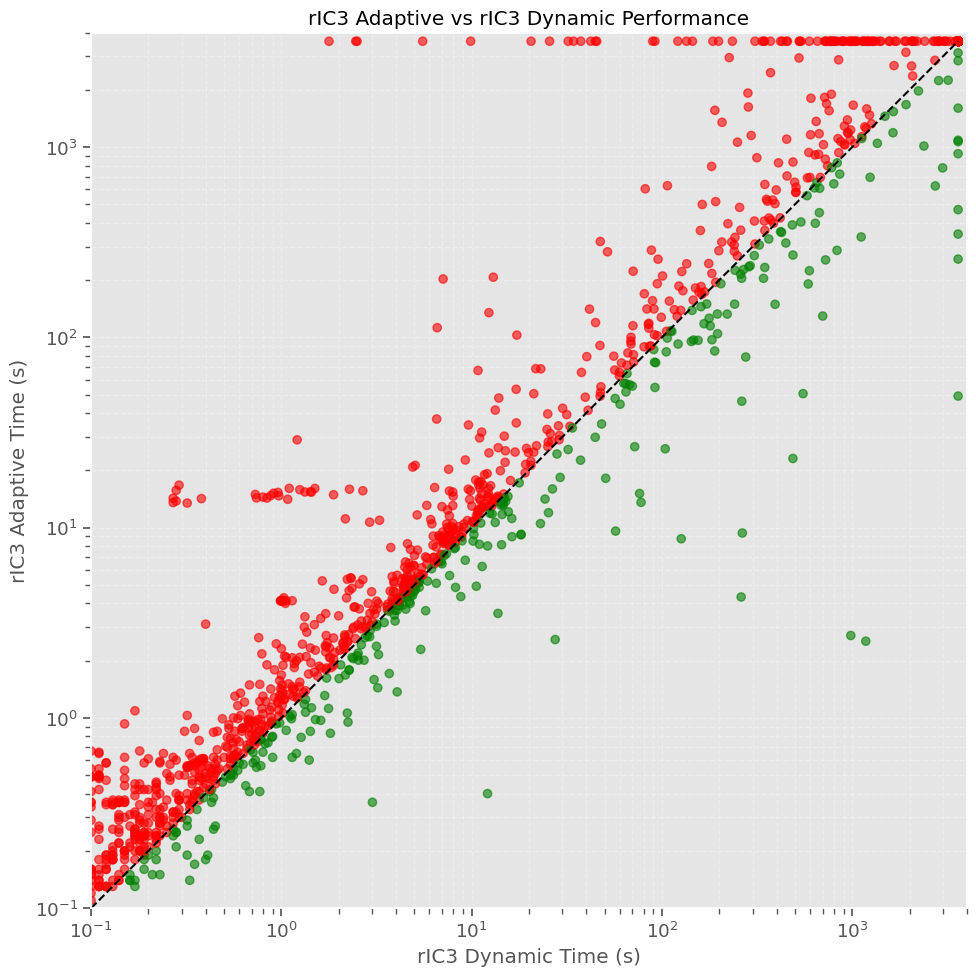

rIC3 Adaptive faster than rIC3 Dynamic: 315 cases (10.9%)
Adaptive vs Dynamic ratio statistics:
count    2798.000000
mean             inf
std              NaN
min         0.000000
25%         0.333333
50%         0.777840
75%         1.000000
max              inf
Name: adaptive_vs_dynamic_ratio, dtype: float64


In [8]:
plt.figure(figsize=(10, 10))

# Create adaptive vs dynamic ratio
results_df["adaptive_vs_dynamic_ratio"] = results_df["ric3_dynamic"] / results_df["ric3_adaptive"]
adaptive_faster_count = sum(results_df["adaptive_vs_dynamic_ratio"] > 1)

total_cases = len(results_df)

plt.scatter(
    results_df["ric3_dynamic"], 
    results_df["ric3_adaptive"], 
    alpha=0.6, 
    c=results_df["adaptive_vs_dynamic_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Dynamic Time (s)')
plt.ylabel('rIC3 Adaptive Time (s)')
plt.title('rIC3 Adaptive vs rIC3 Dynamic Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_comparison_adaptive_vs_dynamic.png', dpi=300)
plt.show()

print(f"rIC3 Adaptive faster than rIC3 Dynamic: {adaptive_faster_count} cases ({adaptive_faster_count/total_cases:.1%})")
print("Adaptive vs Dynamic ratio statistics:")
print(results_df["adaptive_vs_dynamic_ratio"].describe())

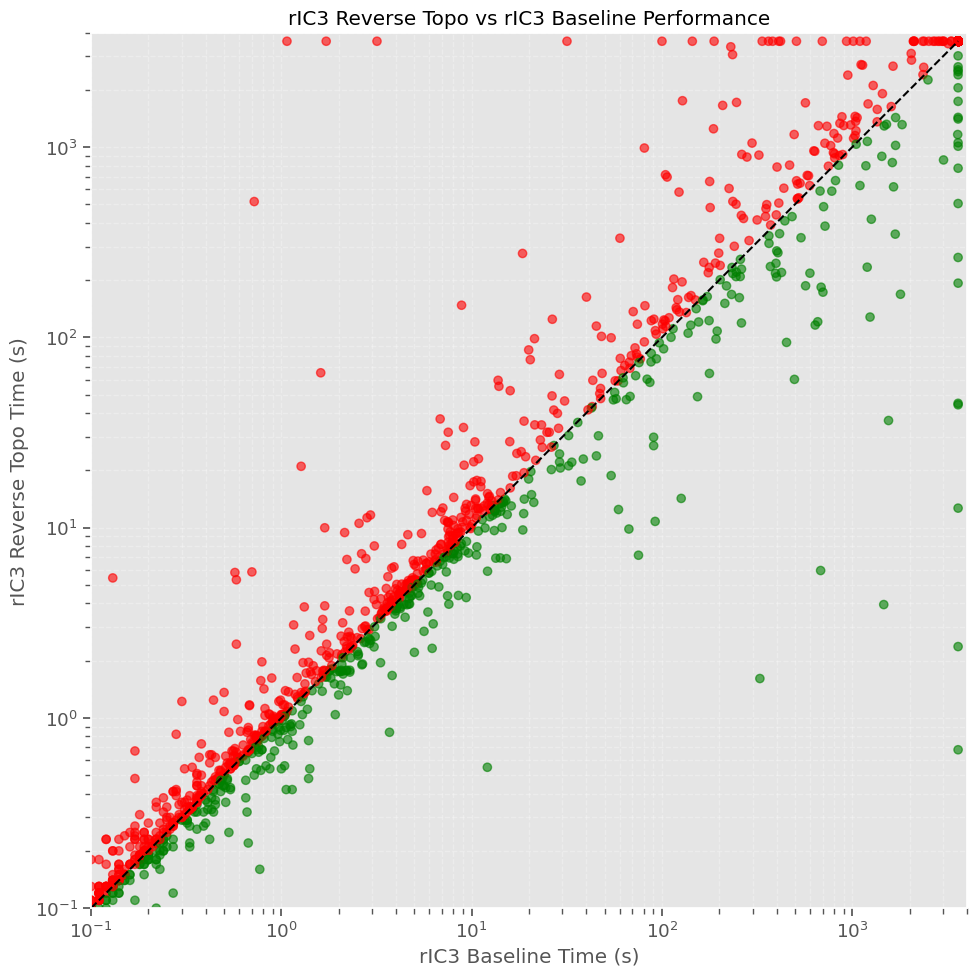

rIC3 Reverse Topo faster than rIC3 Baseline: 510 cases (17.7%)
Reverse Topo vs Baseline ratio statistics:
count    2443.000000
mean             inf
std              NaN
min         0.000000
25%         0.952258
50%         1.000000
75%         1.000000
max              inf
Name: reverse_vs_baseline_ratio, dtype: float64


In [9]:
plt.figure(figsize=(10, 10))

# Create reverse topo vs baseline ratio
results_df["reverse_vs_baseline_ratio"] = results_df["ric3_baseline"] / results_df["ric3_reverse_topo"]
reverse_faster_count = sum(results_df["reverse_vs_baseline_ratio"] > 1)

total_cases = len(results_df)

plt.scatter(
    results_df["ric3_baseline"], 
    results_df["ric3_reverse_topo"], 
    alpha=0.6, 
    c=results_df["reverse_vs_baseline_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Baseline Time (s)')
plt.ylabel('rIC3 Reverse Topo Time (s)')
plt.title('rIC3 Reverse Topo vs rIC3 Baseline Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_comparison_reverse_vs_baseline.png', dpi=300)
plt.show()

print(f"rIC3 Reverse Topo faster than rIC3 Baseline: {reverse_faster_count} cases ({reverse_faster_count/total_cases:.1%})")
print("Reverse Topo vs Baseline ratio statistics:")
print(results_df["reverse_vs_baseline_ratio"].describe())

2879


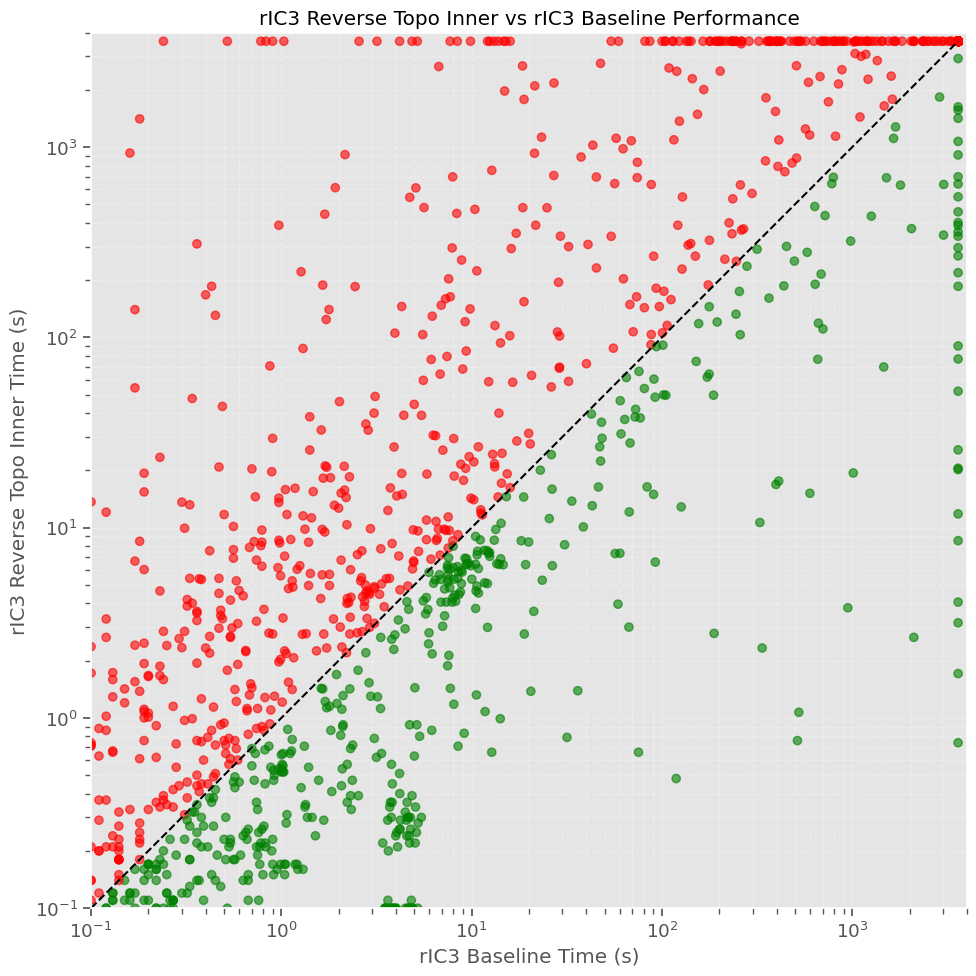

rIC3 Reverse Topo Inner faster than rIC3 Baseline: 921 cases (32.0%)
Reverse Topo Inner vs Baseline ratio statistics:
count    2468.000000
mean             inf
std              NaN
min         0.000000
25%         0.567701
50%         1.000000
75%         2.000000
max              inf
Name: reverse_topo_inn_vs_baseline_ratio, dtype: float64


In [10]:
plt.figure(figsize=(10, 10))

# Create reverse topo inn vs baseline ratio
results_df["reverse_topo_inn_vs_baseline_ratio"] = results_df["ric3_baseline"] / results_df["ric3_reverse_topo_inn"]
reverse_topo_inn_faster_count = sum(results_df["reverse_topo_inn_vs_baseline_ratio"] > 1)

total_cases = len(results_df)
print(total_cases)

plt.scatter(
    results_df["ric3_baseline"], 
    results_df["ric3_reverse_topo_inn"], 
    alpha=0.6, 
    c=results_df["reverse_topo_inn_vs_baseline_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Baseline Time (s)')
plt.ylabel('rIC3 Reverse Topo Inner Time (s)')
plt.title('rIC3 Reverse Topo Inner vs rIC3 Baseline Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_comparison_reverse_topo_inn_vs_baseline.png', dpi=300)
plt.show()

print(f"rIC3 Reverse Topo Inner faster than rIC3 Baseline: {reverse_topo_inn_faster_count} cases ({reverse_topo_inn_faster_count/total_cases:.1%})")
print("Reverse Topo Inner vs Baseline ratio statistics:")
print(results_df["reverse_topo_inn_vs_baseline_ratio"].describe())

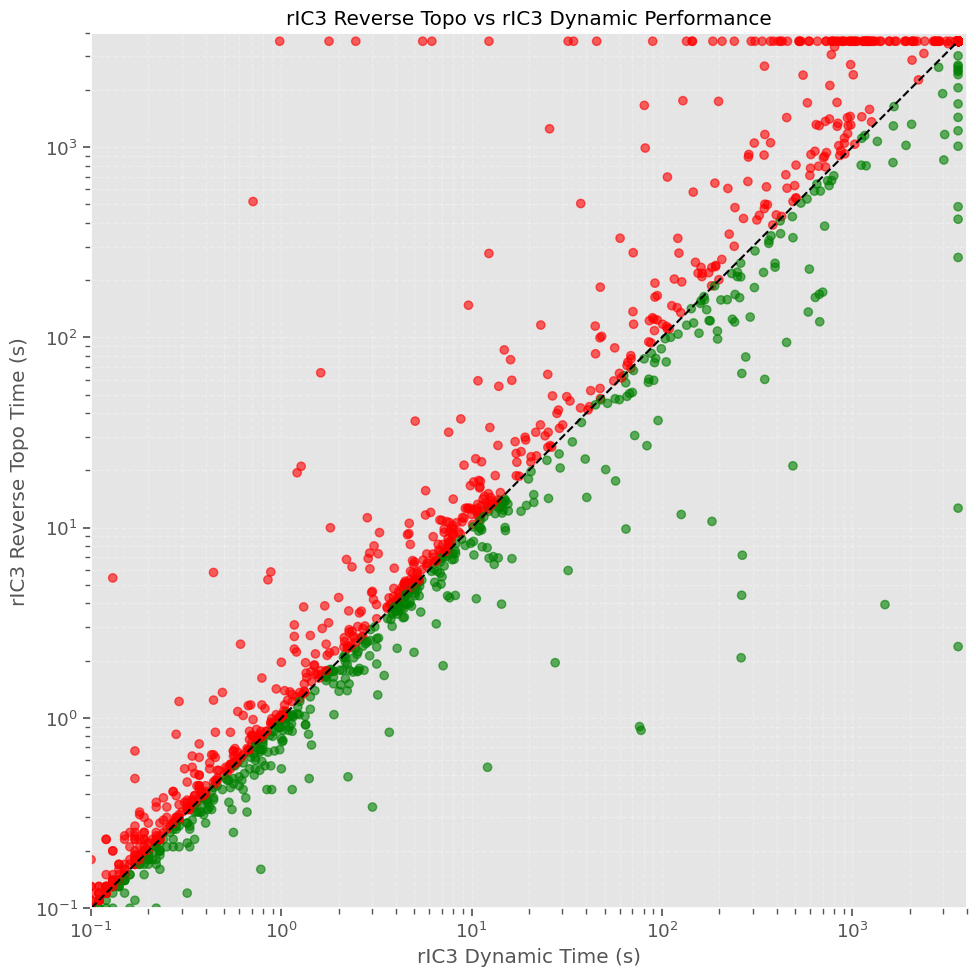

rIC3 Reverse Topo faster than rIC3 Dynamic: 571 cases (19.8%)
Reverse Topo vs Dynamic ratio statistics:
count    2449.000000
mean             inf
std              NaN
min         0.000000
25%         0.937037
50%         1.000000
75%         1.000000
max              inf
Name: reverse_vs_dynamic_ratio, dtype: float64


In [11]:
plt.figure(figsize=(10, 10))

# Create reverse topo vs dynamic ratio
results_df["reverse_vs_dynamic_ratio"] = results_df["ric3_dynamic"] / results_df["ric3_reverse_topo"]
reverse_faster_count = sum(results_df["reverse_vs_dynamic_ratio"] > 1)

total_cases = len(results_df)

plt.scatter(
    results_df["ric3_dynamic"], 
    results_df["ric3_reverse_topo"], 
    alpha=0.6, 
    c=results_df["reverse_vs_dynamic_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Dynamic Time (s)')
plt.ylabel('rIC3 Reverse Topo Time (s)')
plt.title('rIC3 Reverse Topo vs rIC3 Dynamic Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_reverse_topo_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_reverse_topo_comparison.png', dpi=300)
plt.show()

print(f"rIC3 Reverse Topo faster than rIC3 Dynamic: {reverse_faster_count} cases ({reverse_faster_count/total_cases:.1%})")
print("Reverse Topo vs Dynamic ratio statistics:")
print(results_df["reverse_vs_dynamic_ratio"].describe())

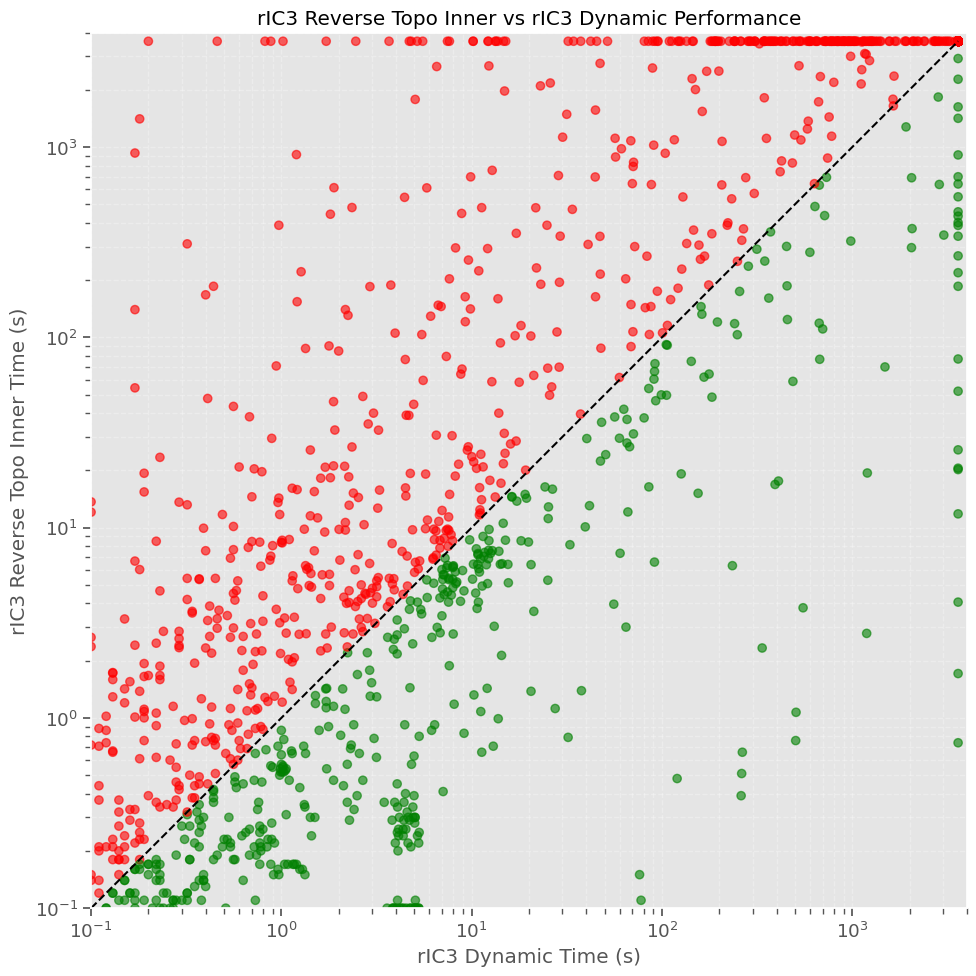

rIC3 Reverse Topo Inner faster than rIC3 Dynamic: 914 cases (31.7%)
Reverse Topo Inner vs Dynamic ratio statistics:
count    2470.0
mean        inf
std         NaN
min         0.0
25%         0.5
50%         1.0
75%         2.0
max         inf
Name: reverse_topo_inn_vs_dynamic_ratio, dtype: float64


In [12]:
plt.figure(figsize=(10, 10))

# Create reverse topo inn vs dynamic ratio
results_df["reverse_topo_inn_vs_dynamic_ratio"] = results_df["ric3_dynamic"] / results_df["ric3_reverse_topo_inn"]
reverse_topo_inn_faster_count = sum(results_df["reverse_topo_inn_vs_dynamic_ratio"] > 1)

total_cases = len(results_df)

plt.scatter(
    results_df["ric3_dynamic"], 
    results_df["ric3_reverse_topo_inn"], 
    alpha=0.6, 
    c=results_df["reverse_topo_inn_vs_dynamic_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Dynamic Time (s)')
plt.ylabel('rIC3 Reverse Topo Inner Time (s)')
plt.title('rIC3 Reverse Topo Inner vs rIC3 Dynamic Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_reverse_topo_inn_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_reverse_topo_inn_comparison.png', dpi=300)
plt.show()

print(f"rIC3 Reverse Topo Inner faster than rIC3 Dynamic: {reverse_topo_inn_faster_count} cases ({reverse_topo_inn_faster_count/total_cases:.1%})")
print("Reverse Topo Inner vs Dynamic ratio statistics:")
print(results_df["reverse_topo_inn_vs_dynamic_ratio"].describe())

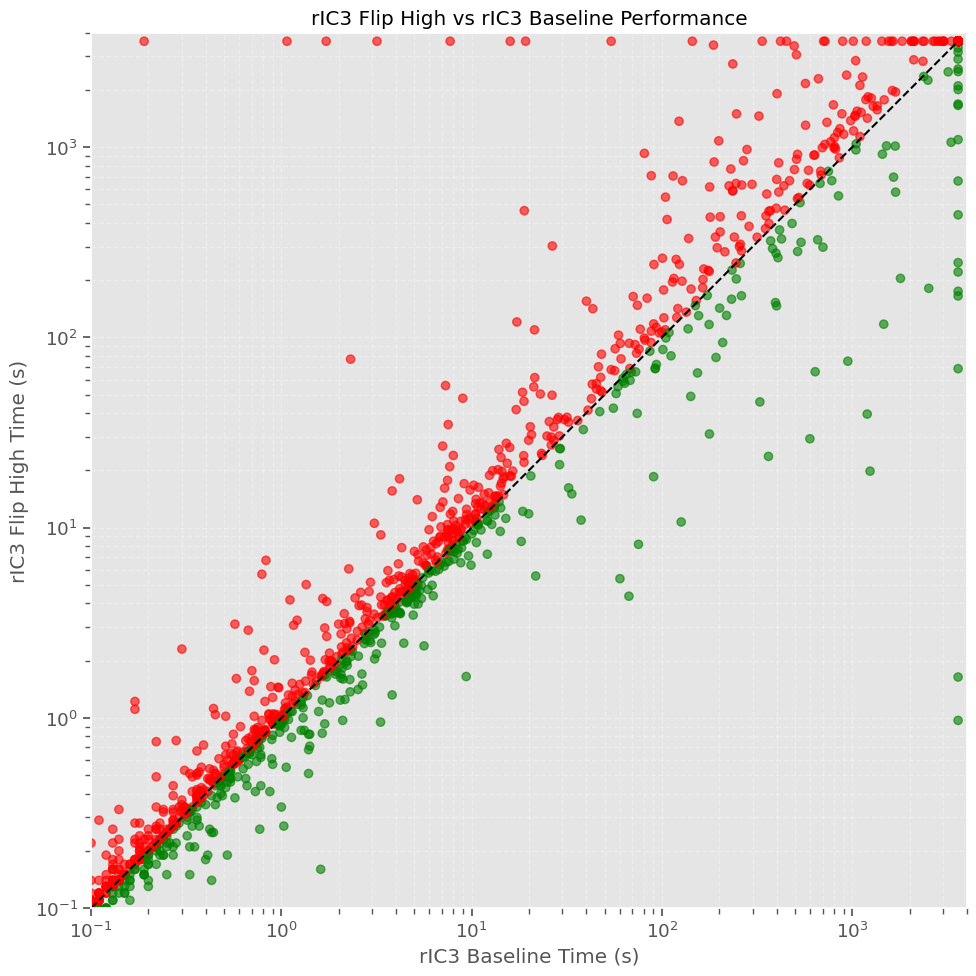

rIC3 Flip High faster than rIC3 Baseline: 519 cases (18.0%)
Flip High vs Baseline ratio statistics:
count    2445.000000
mean             inf
std              NaN
min         0.000000
25%         0.936493
50%         1.000000
75%         1.000000
max              inf
Name: flip_vs_baseline_ratio, dtype: float64


In [13]:
plt.figure(figsize=(10, 10))

# Create flip high vs baseline ratio
results_df["flip_vs_baseline_ratio"] = results_df["ric3_baseline"] / results_df["ric3_flip_high"]
flip_faster_count = sum(results_df["flip_vs_baseline_ratio"] > 1)

total_cases = len(results_df)

plt.scatter(
    results_df["ric3_baseline"], 
    results_df["ric3_flip_high"], 
    alpha=0.6, 
    c=results_df["flip_vs_baseline_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Baseline Time (s)')
plt.ylabel('rIC3 Flip High Time (s)')
plt.title('rIC3 Flip High vs rIC3 Baseline Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_comparison_flip_vs_baseline.png', dpi=300)
plt.show()

print(f"rIC3 Flip High faster than rIC3 Baseline: {flip_faster_count} cases ({flip_faster_count/total_cases:.1%})")
print("Flip High vs Baseline ratio statistics:")
print(results_df["flip_vs_baseline_ratio"].describe())

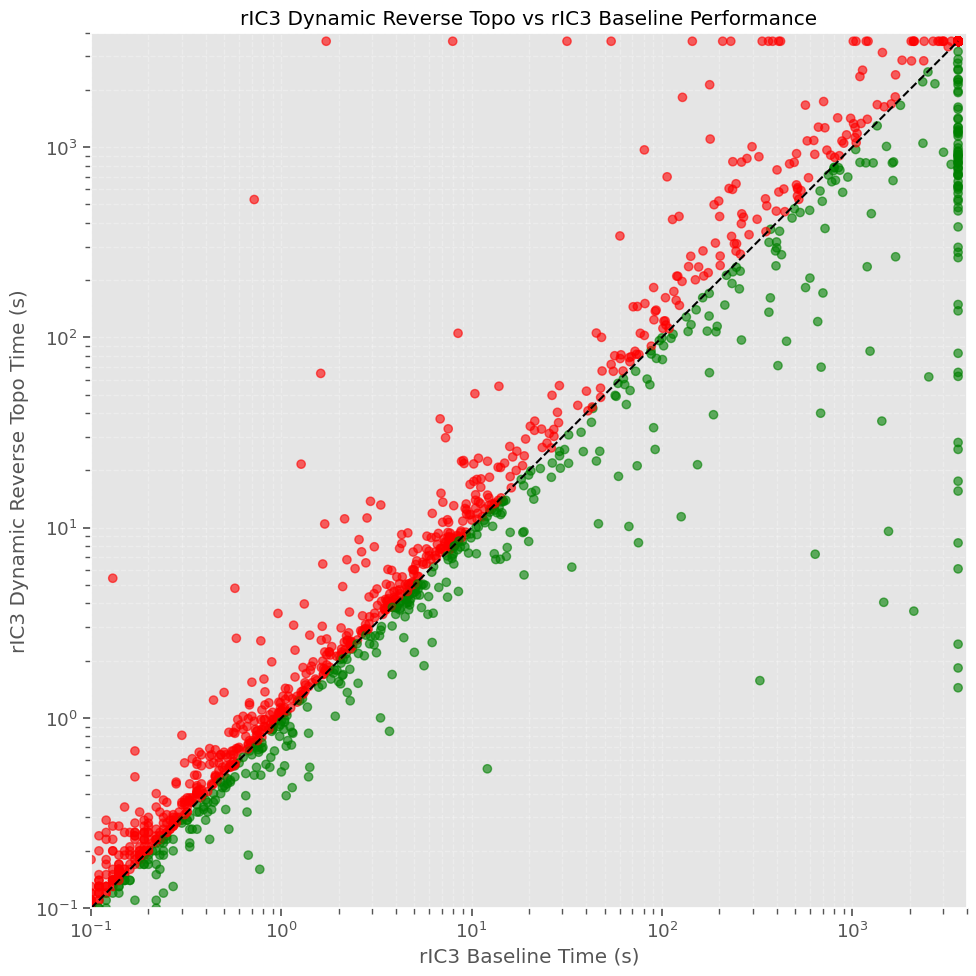

rIC3 Dynamic Reverse Topo faster than rIC3 Baseline: 550 cases (19.1%)
Dynamic Reverse Topo vs Baseline ratio statistics:
count    2450.0
mean        inf
std         NaN
min         0.0
25%         0.9
50%         1.0
75%         1.0
max         inf
Name: dynamic_reverse_topo_vs_baseline_ratio, dtype: float64


In [14]:
plt.figure(figsize=(10, 10))

# Create dynamic reverse topo vs baseline ratio
results_df["dynamic_reverse_topo_vs_baseline_ratio"] = results_df["ric3_baseline"] / results_df["ric3_dynamic_reverse_topo"]
dynamic_faster_count = sum(results_df["dynamic_reverse_topo_vs_baseline_ratio"] > 1)

total_cases = len(results_df)

plt.scatter(
    results_df["ric3_baseline"], 
    results_df["ric3_dynamic_reverse_topo"], 
    alpha=0.6, 
    c=results_df["dynamic_reverse_topo_vs_baseline_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Baseline Time (s)')
plt.ylabel('rIC3 Dynamic Reverse Topo Time (s)')
plt.title('rIC3 Dynamic Reverse Topo vs rIC3 Baseline Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_comparison_dynamic_reverse_topo_vs_baseline.png', dpi=300)
plt.show()

print(f"rIC3 Dynamic Reverse Topo faster than rIC3 Baseline: {dynamic_faster_count} cases ({dynamic_faster_count/total_cases:.1%})")
print("Dynamic Reverse Topo vs Baseline ratio statistics:")
print(results_df["dynamic_reverse_topo_vs_baseline_ratio"].describe())

2879


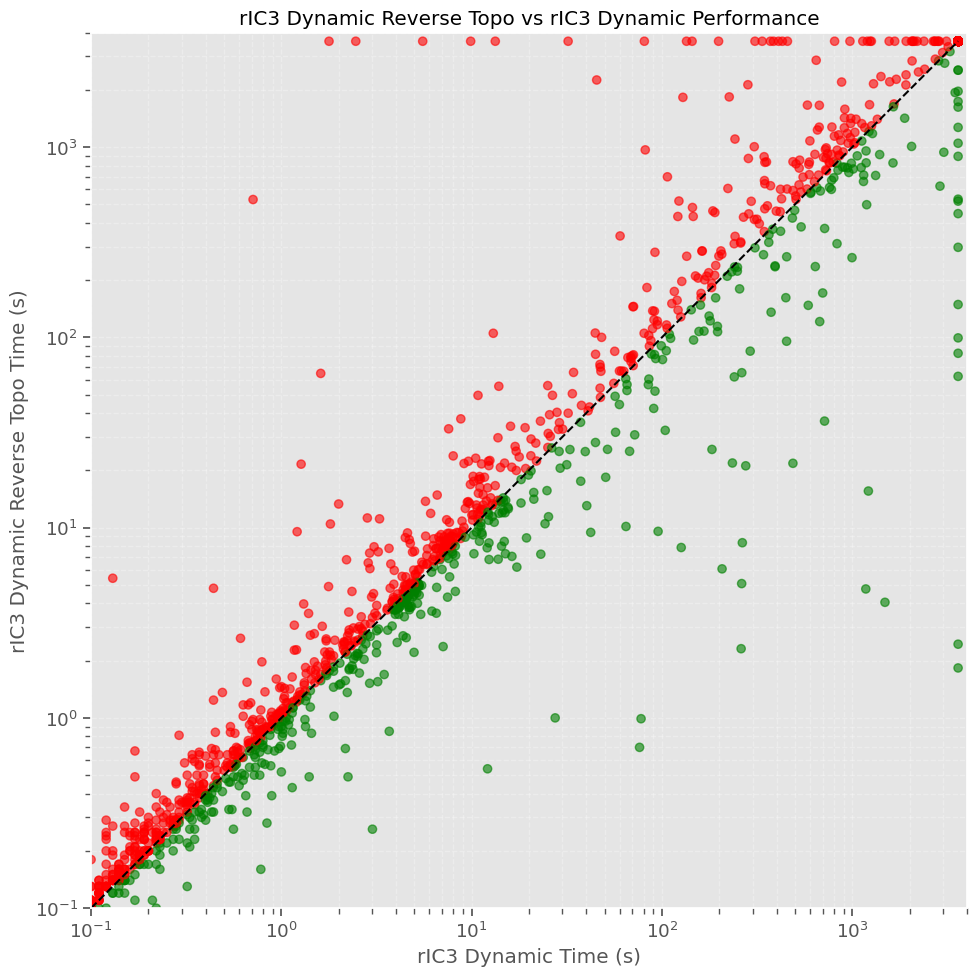

rIC3 Dynamic Reverse Topo faster than rIC3 Dynamic: 539 cases (18.7%)
Dynamic Reverse Topo vs Dynamic ratio statistics:
count    2454.000000
mean             inf
std              NaN
min         0.000000
25%         0.893798
50%         1.000000
75%         1.000000
max              inf
Name: dynamic_reverse_topo_vs_dynamic_ratio, dtype: float64


In [15]:
plt.figure(figsize=(10, 10))

# Create dynamic reverse topo vs dynamic ratio
results_df["dynamic_reverse_topo_vs_dynamic_ratio"] = results_df["ric3_dynamic"] / results_df["ric3_dynamic_reverse_topo"]
dynamic_reverse_topo_faster_count = sum(results_df["dynamic_reverse_topo_vs_dynamic_ratio"] > 1)

total_cases = len(results_df)
print(total_cases)

plt.scatter(
    results_df["ric3_dynamic"], 
    results_df["ric3_dynamic_reverse_topo"], 
    alpha=0.6, 
    c=results_df["dynamic_reverse_topo_vs_dynamic_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Dynamic Time (s)')
plt.ylabel('rIC3 Dynamic Reverse Topo Time (s)')
plt.title('rIC3 Dynamic Reverse Topo vs rIC3 Dynamic Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_comparison_dynamic_reverse_topo_vs_dynamic.png', dpi=300)
plt.show()

print(f"rIC3 Dynamic Reverse Topo faster than rIC3 Dynamic: {dynamic_reverse_topo_faster_count} cases ({dynamic_reverse_topo_faster_count/total_cases:.1%})")
print("Dynamic Reverse Topo vs Dynamic ratio statistics:")
print(results_df["dynamic_reverse_topo_vs_dynamic_ratio"].describe())

2879


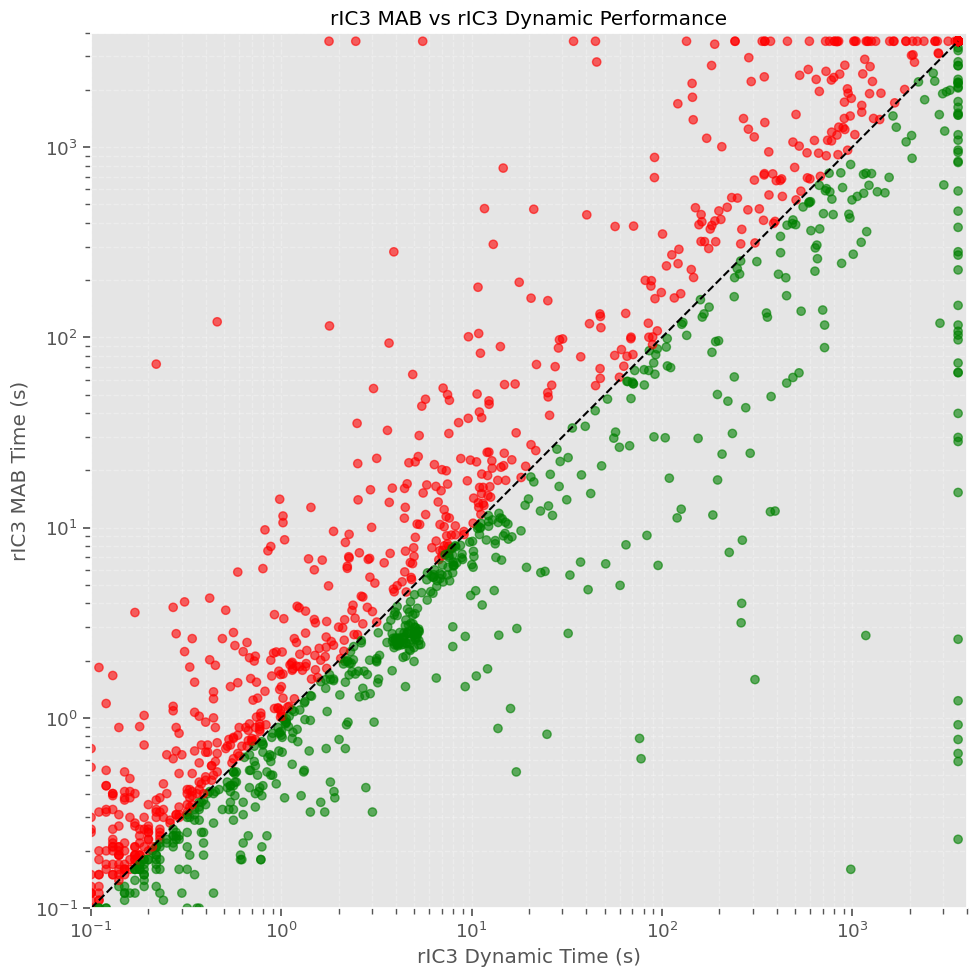

rIC3 MAB faster than rIC3 Dynamic: 1607 cases (55.8%)
MAB vs Dynamic ratio statistics:
count    2566.000000
mean             inf
std              NaN
min         0.000000
25%         0.666667
50%         1.000000
75%         1.100000
max              inf
Name: mab_vs_dynamic_ratio, dtype: float64
Dynamic >=3600 but MAB < 3600: 47 cases
Dynamic solve in total: 2267 cases
MAB solve in total: 2273 cases


In [18]:
plt.figure(figsize=(10, 10))

# Create mab vs dynamic ratio
results_df["mab_vs_dynamic_ratio"] = results_df["ric3_dynamic"] / results_df["ric3_mab"]
mab_faster_count = sum(results_df["mab_vs_dynamic_ratio"] >= 1)

total_cases = len(results_df)
print(total_cases)

plt.scatter(
    results_df["ric3_dynamic"], 
    results_df["ric3_mab"], 
    alpha=0.6, 
    c=results_df["mab_vs_dynamic_ratio"].apply(lambda x: 'green' if x > 1 else 'red')
)
plt.plot([0.1, 3600], [0.1, 3600], 'k--')  # Diagonal line: y=x
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rIC3 Dynamic Time (s)')
plt.ylabel('rIC3 MAB Time (s)')
plt.title('rIC3 MAB vs rIC3 Dynamic Performance')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0.1, 4000)
plt.ylim(0.1, 4000)

plt.tight_layout()
plt.savefig('ric3_comparison.png', dpi=300)
# save to emp_eval_slidev/figures/ 
plt.savefig('emp_eval_slidev/figures/ric3_comparison_dynamic_vs_mab.png', dpi=300)
plt.show()

print(f"rIC3 MAB faster than rIC3 Dynamic: {mab_faster_count} cases ({mab_faster_count/total_cases:.1%})")
print("MAB vs Dynamic ratio statistics:")
print(results_df["mab_vs_dynamic_ratio"].describe())

# print how many case that dynamic >=3600 but mab < 3600
print(f"Dynamic >=3600 but MAB < 3600: {sum((results_df['ric3_dynamic'] >= 3600) & (results_df['ric3_mab'] < 3600))} cases")

# print dynamic solve in total
print(f"Dynamic solve in total: {sum(results_df['ric3_dynamic'] < 3600)} cases")

# print mab solve in total
print(f"MAB solve in total: {sum(results_df['ric3_mab'] < 3600)} cases")
# dump result to csv 
# results_df.to_csv('solver_comparison_results.csv', index=False)
# dump csv that dynamic < 3600 and mab >= 3600 
dynamic_only_unsolved = results_df[(results_df['ric3_dynamic'] < 3600) & (results_df['ric3_mab'] >= 3600)]
dynamic_only_unsolved.to_csv('dynamic_only_unsolved_cases.csv', index=False)

mab_only_unsolved = results_df[(results_df['ric3_dynamic'] >= 3600) & (results_df['ric3_mab'] < 3600)]
mab_only_unsolved.to_csv('mab_only_unsolved_cases.csv', index=False)

## Save Results to CSV

Store the processed results for later reference.

In [17]:
# Save results to CSV
results_df.to_csv('solver_comparison_results.csv', index=False)
print("Results saved to 'solver_comparison_results.csv'")

Results saved to 'solver_comparison_results.csv'
